In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import sys
import os
import random
import gc
import subprocess
import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('./stylelib/custom.mplstyle')

## Extract a random sample 1% of the original size

In [4]:
%%time
raw_csv = './data/train.csv'
sample_csv = './data/train_sample.csv'
need_to_sample = False

if need_to_sample:
    result = subprocess.check_output('wc -l {}'.format(raw_csv), shell=True)
    nlines_total = int(result.split()[0])
    nlines_sample = int(0.01 * nlines_total)
    subprocess.call('head -1 {} > {}'.format(raw_csv, sample_csv), shell=True)
    subprocess.call('gshuf -n {} {} >> {}'.format(nlines_sample, raw_csv, sample_csv), shell=True)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 5.72 µs


In [5]:
print(nlines_total, nlines_sample)

184903891 1849038


In [128]:
# Load sampled csv into pandas dataframe, sort by click time (and reset index)
df = pd.read_csv(
    sample_csv, parse_dates=['click_time', 'attributed_time']
).sort_values(by='click_time').reset_index()

In [129]:
df.head()

,index,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,1276657,53418,3,1,17,379,2017-11-06 14:44:52,NaT,0
1,1334333,84644,3,1,19,379,2017-11-06 14:56:49,NaT,0
2,1372212,38683,3,1,19,379,2017-11-06 15:08:26,NaT,0
3,956786,3653,3,1,18,379,2017-11-06 15:21:34,NaT,0
4,1679204,191880,3,1,18,379,2017-11-06 15:42:20,NaT,0


In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1849038 entries, 0 to 1849037
Data columns (total 9 columns):
index              int64
ip                 int64
app                int64
device             int64
os                 int64
channel            int64
click_time         datetime64[ns]
attributed_time    datetime64[ns]
is_attributed      int64
dtypes: datetime64[ns](2), int64(7)
memory usage: 127.0 MB


In [131]:
for col in ['click_time', 'attributed_time']:
    df[col] = pd.DatetimeIndex(df[col]).tz_localize('utc').tz_convert('Asia/Shanghai')

In [132]:
df['delta_time_click_vs_attr'] = (df['attributed_time'] - df['click_time']).dt.total_seconds()
df['delta_time_click_vs_attr'].describe()

count     4588.000000
mean      5197.161726
std      10426.189964
min          0.000000
25%         56.000000
50%        283.500000
75%       4710.250000
max      84269.000000
Name: delta_time_click_vs_attr, dtype: float64

In [133]:
df['click_hour'] = df['click_time'].dt.hour
df['attr_hour'] = df['attributed_time'].dt.hour
df.head()

,index,ip,app,device,os,channel,click_time,attributed_time,is_attributed,delta_time_click_vs_attr,click_hour,attr_hour
0,1276657,53418,3,1,17,379,2017-11-06 22:44:52+08:00,NaT,0,NaN,22,NaN
1,1334333,84644,3,1,19,379,2017-11-06 22:56:49+08:00,NaT,0,NaN,22,NaN
2,1372212,38683,3,1,19,379,2017-11-06 23:08:26+08:00,NaT,0,NaN,23,NaN
3,956786,3653,3,1,18,379,2017-11-06 23:21:34+08:00,NaT,0,NaN,23,NaN
4,1679204,191880,3,1,18,379,2017-11-06 23:42:20+08:00,NaT,0,NaN,23,NaN


In [134]:
df_unique = pd.DataFrame(df.nunique()).T
df_unique

,index,ip,app,device,os,channel,click_time,attributed_time,is_attributed,delta_time_click_vs_attr,click_hour,attr_hour
0,1849038,96420,323,569,229,176,248175,4538,2,2339,24,24


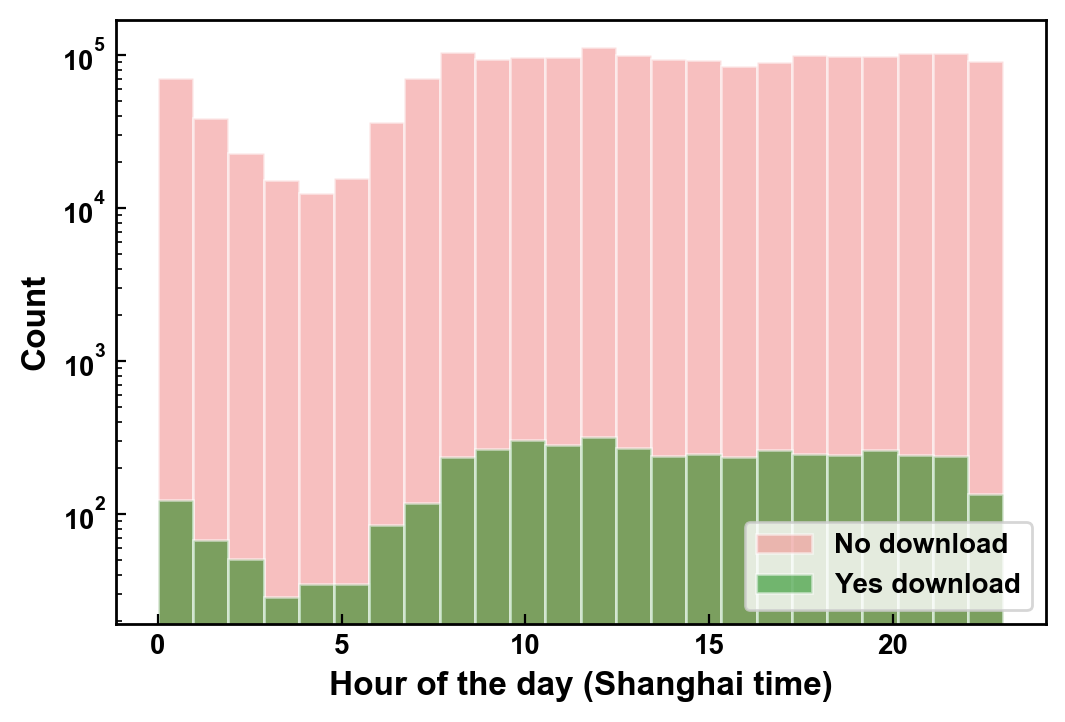

In [135]:
hist_params = dict(bins=24, edgecolor='w', alpha=0.5)
no_params = dict(facecolor='lightcoral', label='No download')
yes_params = dict(facecolor='green', label='Yes download')
fig, ax = plt.subplots()
metric = 'click_hour'
ax.hist(df[df['is_attributed'] == 0][metric], **hist_params, **no_params)
ax.hist(df[df['is_attributed'] == 1][metric], **hist_params, **yes_params)
ax.legend(loc=4)
ax.set(
    yscale='log', xlabel='Hour of the day (Shanghai time)', ylabel='Count'
)
plt.show();

In [143]:
attr_ref = 'ip'
attr_list = ['click_hour', 'os', 'device', 'channel']
df_engineered = df.copy()

for attr_other in attr_list:
    print(attr_other)
    df_temp = df.groupby([attr_ref, attr_other]).count()['app']
    df_temp = df_temp.reset_index().rename(columns={'app' : 'count_ip-by-{}'.format(attr_other)})
    df_summary = df.merge(df_temp, how='outer', on=['ip', '{}'.format(attr_other)])
    df_engineered['count_ip-by-{}'.format(attr_other)] = df_summary['count_ip-by-{}'.format(attr_other)]

click_hour
os
device
channel


In [144]:
df_engineered.head()

,index,ip,app,device,os,channel,click_time,attributed_time,is_attributed,delta_time_click_vs_attr,click_hour,attr_hour,count_ip-by-click_hour,count_ip-by-os,count_ip-by-device,count_ip-by-channel
0,1276657,53418,3,1,17,379,2017-11-06 22:44:52+08:00,NaT,0,NaN,22,NaN,2,2,22,1
1,1334333,84644,3,1,19,379,2017-11-06 22:56:49+08:00,NaT,0,NaN,22,NaN,2,2,22,11
2,1372212,38683,3,1,19,379,2017-11-06 23:08:26+08:00,NaT,0,NaN,23,NaN,98,125,22,11
3,956786,3653,3,1,18,379,2017-11-06 23:21:34+08:00,NaT,0,NaN,23,NaN,98,125,22,11
4,1679204,191880,3,1,18,379,2017-11-06 23:42:20+08:00,NaT,0,NaN,23,NaN,98,125,22,11


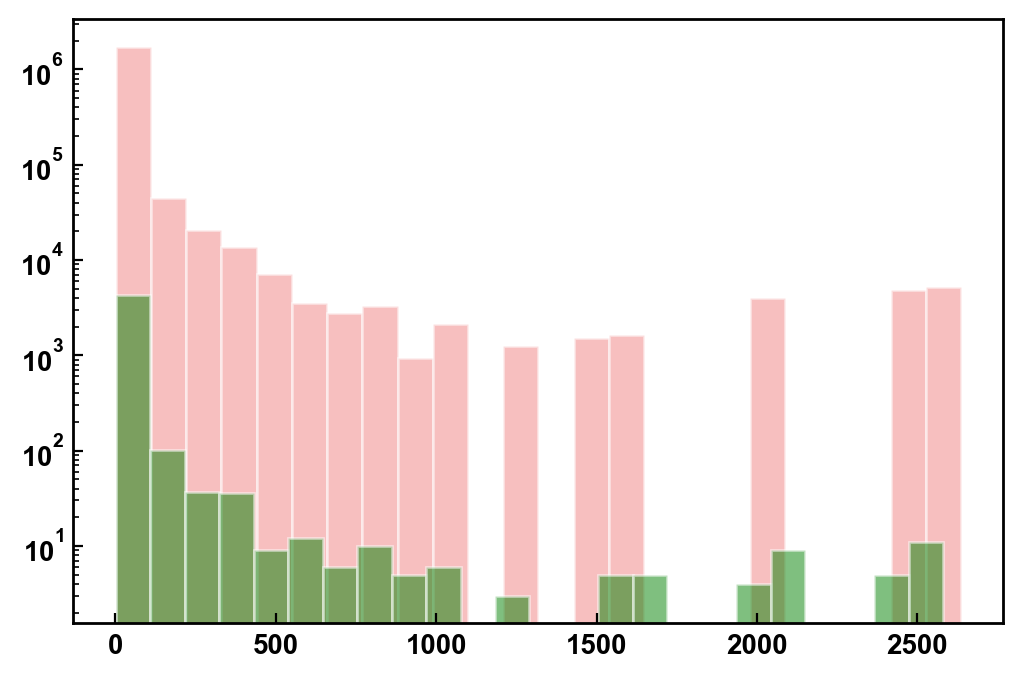

In [147]:
fig, ax = plt.subplots()
metric = 'count_ip-by-os'
ax.hist(
    df_engineered[df_engineered['is_attributed'] == 0][metric], **hist_params, **no_params
)
ax.hist(
    df_engineered[df_engineered['is_attributed'] == 1][metric], **hist_params, **yes_params
)
ax.set(yscale='log')
plt.show();